In [1]:
from obs_models import *
from generate_data import *
from utils import *
%matplotlib inline

In [2]:
from scipy.stats import multivariate_normal

In [3]:
N, D = 1000, 10
random_locs = np.random.randn(D)*10
random_covariance_factor = np.random.rand(D,D)*np.random.randint(2,size=D*D).reshape(D,D)
random_covariance = np.matmul(random_covariance_factor,random_covariance_factor.T)
random_data = multivariate_normal(mean=random_locs,cov=random_covariance).rvs(size=N)

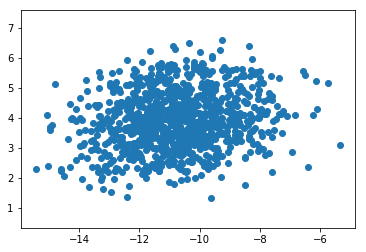

In [4]:
# plot two random dimensions against each other
pyplot.scatter(*random_data[:,np.random.choice(np.arange(D),size=2,replace=False)].T)
pyplot.axis('equal');

In [10]:
class IndependentGaussian:
    """Base class for compositional models"""
    def __init__(self, X):
        if not type(X) is torch.Tensor:
            X = torch.Tensor(X)
        self.X = X
        self.N, self.D = X.shape
        self.conditioned_model = None
        
    def __repr__(self):
        return 'G'
    
    def model(self, X):
        with pyro.plate('features', self.D):
            loc = pyro.sample('loc', dst.Normal(0.,10.))
            scale = pyro.sample('scale', dst.LogNormal(0.,4.))
            with pyro.plate('X', self.N):
                X = pyro.sample('obs', dst.Normal(loc,scale))
        return X
    
    def conditionModel(self, X):
        if self.conditioned_model is None:
            self.conditioned_model = pyro.condition(self.model, data = {'obs': X})
        return self.conditioned_model(X)
    
    def guide(self, X):
        # MAP
        with pyro.plate('features', self.D):
            loc_delta = pyro.param('loc_delta', torch.zeros(self.D))
            scale_delta = pyro.param('scale_delta', torch.ones(self.D), constraint=constraints.positive)
            loc = pyro.sample('loc', dst.Delta(loc_delta))
            scale = pyro.sample('scale', dst.Delta(scale_delta))
        return loc, scale
        
    def inference(self):
        X = self.X
        self.conditionModel(X)
        def per_param_callable(module_name, param_name):
            #if param_name == 'loc_mean':
            #    return {"lr": 0.0, 'betas': [0.9, 0.99]}
            #else:
            #    return {"lr": 0.01, 'betas': [0.9, 0.99]}
            return {"lr": 0.01, 'betas': [0.9, 0.99]}

        def initialize(seed):
            # evaluate loss on a randomly initialized parameter-set 
            pyro.set_rng_seed(seed)
            pyro.clear_param_store()
            # guide param names were defined by AutoDelta, with names copied from model and prefixed by 'auto_'
            # Initialize means to a single sample of X.
            pyro.param('loc', X.mean(0))
            pyro.param('scale', X.std(0), constraint=constraints.positive)
            # WHY DO I GET AN ERROR WHEN USING PYRO.CONDITION?
            #loss = svi.loss(cond_model, global_guide, X)
            loss = svi.loss(self.conditioned_model, self.guide, self.X)
            return loss

        optim = pyro.optim.Adam(per_param_callable)
        elbo = Trace_ELBO()
        svi = SVI(self.conditioned_model, self.guide, optim, loss=elbo)

        loss, seed = min((initialize(seed), seed) for seed in range(100))
        initialize(seed)
        
        # Register hooks to monitor gradient norms.
        self.gradient_norms = defaultdict(list)
        for name, value in pyro.get_param_store().named_parameters():
            value.register_hook(lambda g, name=name: self.gradient_norms[name].append(g.norm().item()))

        self.losses = []
        for i in range(3000):
            loss = svi.step(X)
            self.losses.append(loss)
            print('.' if i % 100 else '\n', end='')
    
    def plot_learning_curve(self):
        pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
        pyplot.plot(self.losses)
        pyplot.xlabel('iters')
        pyplot.ylabel('loss')
        pyplot.yscale('log')
        pyplot.title('Convergence of SVI');
        
    def plot_gradient_norms(self):
        pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
        for name, grad_norms in self.gradient_norms.items():
            pyplot.plot(grad_norms, label=name)
        pyplot.xlabel('iters')
        pyplot.ylabel('gradient norm')
        pyplot.yscale('log')
        pyplot.legend(loc='best')
        pyplot.title('Gradient norms during SVI');
        
    def predictive_check(self):
        variatonal_posterior_sample = dict(zip(['loc','scale'],self.guide(self.X)))
        posterior_predictive = pyro.condition(self.model, data = variatonal_posterior_sample)
        return posterior_predictive(self.X).detach().numpy()

In [11]:
tmp = IndependentGaussian(random_data)

In [12]:
# trace of conditioned model is empty?
#trace = pyro.poutine.trace(tmp.conditioned_model).get_trace()
trace = pyro.poutine.trace(tmp.model).get_trace(random_data)

In [13]:
trace.log_prob_sum()

tensor(-1802.1819, grad_fn=<AddBackward0>)

In [14]:
tmp.inference()


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

In [15]:
?pyro.infer.EmpiricalMarginal

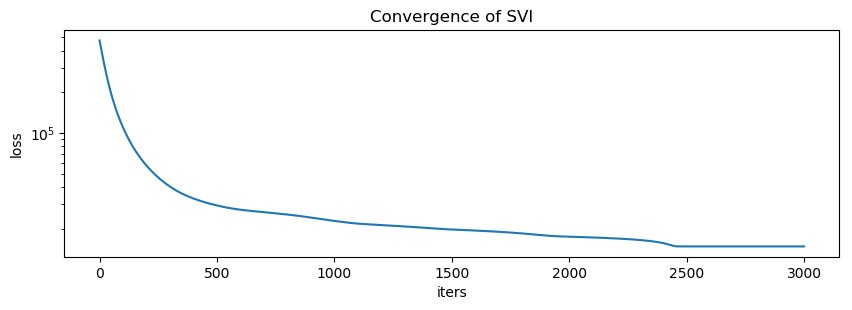

In [16]:
tmp.plot_learning_curve()

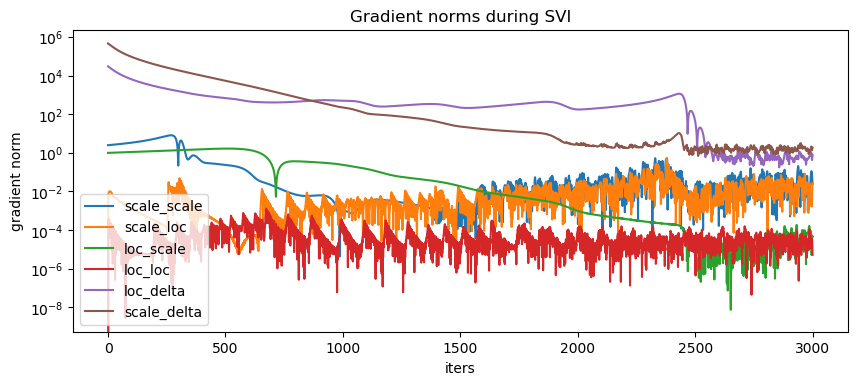

In [17]:
tmp.plot_gradient_norms()

In [ ]:
# plot two random dimensions against each other
random_idx = np.random.choice(np.arange(D),size=2,replace=False)
pyplot.scatter(*random_data[:,random_idx].T, alpha=.2)
pyplot.scatter(*tmp.predictive_check()[:,random_idx].T, alpha=.1)
pyplot.axis('equal');

In [ ]:
m_trace = pyro.poutine.trace(tmp.model).get_trace(random_data)

In [ ]:
m_trace.log_prob_sum()

In [ ]:
m_trace.

In [ ]:
for name, node in m_trace.nodes.items():
    if node['type'] is 'sample':
        print(name, node, node['fn'])

In [ ]:
g_trace = pyro.poutine.trace(tmp.guide).get_trace(random_data)

In [ ]:
g_trace.log_prob_sum()

In [ ]:
for name, node in g_trace.nodes.items():
    if node['type'] is 'sample':
        print(name, node, node['fn'])